<a href="https://colab.research.google.com/github/hvauchar/Marathi-to-English-Neural-Machine-Translation/blob/master/NMT_mar%3D%3Eeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/neural-machine-translation/marathi
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/neural-machine-translation/marathi
 mar.txt      'NMT-mar=>eng.ipynb'    training_checkpoints
 Nirmala.ttf   NMT-perditions.ipynb


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')
def preprocess_sentence(w):
  w = w.lower().strip()
  w = re.sub(r"([?.!,¿।])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"उडी मारा!"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> may i borrow this book ? <end>
<start> उडी मारा ! <end>


In [0]:
def create_dataset(path, num_examples):
  lines = io.open('mar.txt', encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines]
  return zip(*word_pairs)

In [0]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [7]:
en, sp = create_dataset('mar.txt',None)
print(en[-1])
print(sp[-1])

<start> in 1969 , roger miller recorded a song called you don't want my love . today , this song is better known as in the summer time . it's the first song he wrote and sang that became popular . <end>
<start> १९६९मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावाचं गाणं रेकॉर्ड केलं . आज हे गाणं इन द समर टाइम म्हणून जास्त प्रसिद्ध आहे . त्याने लिहिलेलं व गायलेलं हे असं पहिलं गाणं होतं जे लोकप्रिय झालं . <end>


In [8]:
for i in sp[:20]:
  print(i)

<start> जा . <end>
<start> पळ ! <end>
<start> धाव ! <end>
<start> पळा ! <end>
<start> धावा ! <end>
<start> कोण ? <end>
<start> वाह ! <end>
<start> आग ! <end>
<start> फायर ! <end>
<start> वाचवा ! <end>
<start> वाचव ! <end>
<start> उडी मार ! <end>
<start> उडी मारा ! <end>
<start> उडी मार . <end>
<start> उडी मारा . <end>
<start> थांबा ! <end>
<start> थांब ! <end>
<start> थांबा ! <end>
<start> थांब ! <end>
<start> हॅलो ! <end>


In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
path_to_file = 'mar.txt'
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [11]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

30956 30956 7740 7740


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
283 ----> जाऊन
939 ----> दुसरं
121 ----> काहीतरी
139 ----> कर
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
41 ----> go
15 ----> do
126 ----> something
261 ----> else
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 40]), TensorShape([64, 42]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    print(self.batch_sz, self.enc_units)
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
sample_hidden.shape

64 1024
Encoder output shape: (batch size, sequence length, units) (64, 40, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


TensorShape([64, 1024])

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 40, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5831)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  
  checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
# Epoch 10 Batch 0 Loss 0.9000
# Epoch 10 Loss 0.9349
# Time taken for 1 epoch 340
# .163818359375 sec

64 1024
Epoch 1 Batch 0 Loss 1.5354
Epoch 1 Batch 100 Loss 0.7898
Epoch 1 Batch 200 Loss 0.6608
Epoch 1 Batch 300 Loss 0.6672
Epoch 1 Batch 400 Loss 0.6126
Epoch 1 Loss 0.7116
Time taken for 1 epoch 9584.075722932816 sec

64 1024
Epoch 2 Batch 0 Loss 0.5899
Epoch 2 Batch 100 Loss 0.5186
Epoch 2 Batch 200 Loss 0.5247
Epoch 2 Batch 300 Loss 0.5088
Epoch 2 Batch 400 Loss 0.4195
Epoch 2 Loss 0.4901
Time taken for 1 epoch 9492.674482107162 sec

64 1024
Epoch 3 Batch 0 Loss 0.4059
Epoch 3 Batch 100 Loss 0.3461
Epoch 3 Batch 200 Loss 0.3581
Epoch 3 Batch 300 Loss 0.4242


In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

'./training_checkpoints/ckpt-1'

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
from matplotlib.font_manager import FontProperties
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}
  hindi_font = FontProperties(fname = 'Nirmala.ttf')
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90,fontproperties=hindi_font)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [27]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
from matplotlib.font_manager import FontProperties
def plot_attention(attention, sentence, predicted_sentence,psen):
  fontdict = {'fontsize': 14}
  hindi_font = FontProperties(fname = 'Nirmala.ttf',size=20)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  fig.suptitle('Input: '+' '.join(sentence[1:-1])+'\n'+'Predicted translation: '+' '.join(predicted_sentence[:-2]),fontproperties=hindi_font)
  ax.matshow(attention, cmap='viridis')
  
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=0,fontproperties=hindi_font)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '),sentence)

In [0]:
for i in sp[1000:1030]:
  print(i)

<start> मला बोलू द्या . <end>
<start> चला सुरुवात करू ! <end>
<start> चला सुरुवात करू या ! <end>
<start> वर जाऊ या . <end>
<start> वरती जाऊ या . <end>
<start> निघू या . <end>
<start> चला सुरुवात करू ! <end>
<start> चला सुरुवात करू या ! <end>
<start> आजूबाजूला बघ . <end>
<start> आजूबाजूला बघा . <end>
<start> पाठ कर . <end>
<start> पैसा बोलतो . <end>
<start> नाही म्हणजे नाही . <end>
<start> कोणीही आलं नाही . <end>
<start> कोणीच आलं नाही . <end>
<start> कोणीही मेलं नाही . <end>
<start> कोणीही खोटं बोललं नाही . <end>
<start> आता तू करून बघ . <end>
<start> आता तुम्ही करून बघा . <end>
<start> आता तू प्रयत्न कर . <end>
<start> आता तुम्ही प्रयत्न करा . <end>
<start> आता तू प्रयत्न करून बघ . <end>
<start> आता तुम्ही प्रयत्न करून बघा . <end>
<start> बरं , तूच जिंकलास . <end>
<start> बरं , तूच जिंकलीस . <end>
<start> बरं , तू जिंकलास . <end>
<start> बरं , तू जिंकलीस . <end>
<start> लक्षात ठेव . <end>
<start> लक्षात ठेवा . <end>
<start> टॉमला आत पाठवा . <end>


Input: <start> मी विसरलो . <end>
Predicted translation: i forgot it . <end> 


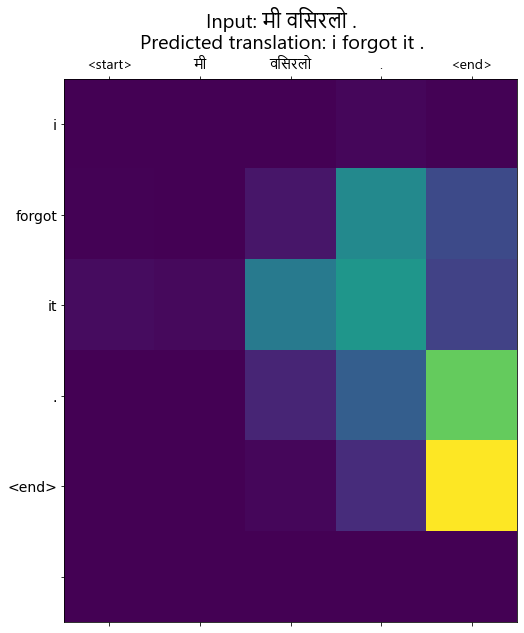

In [30]:
translate(u'मी विसरलो.')

Input: <start> मी फोन केला . <end>
Predicted translation: i phoned . <end> 


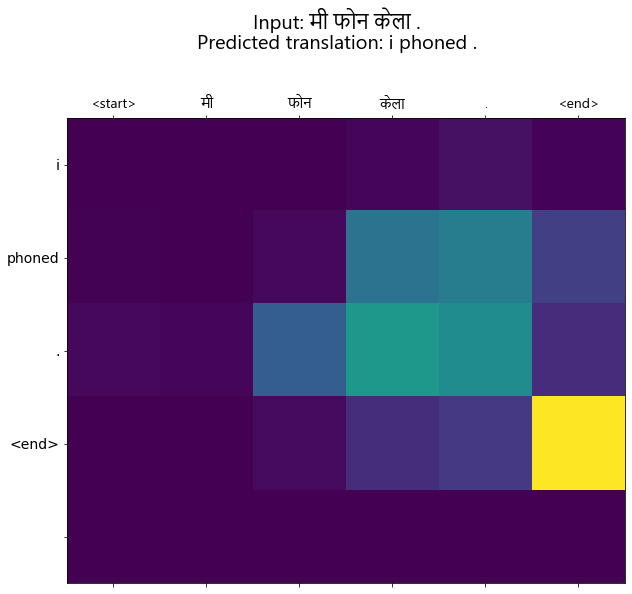

In [0]:
translate(u'मी फोन केला.')

Input: <start> मला बोलू द्या . <end>
Predicted translation: let me talk . <end> 


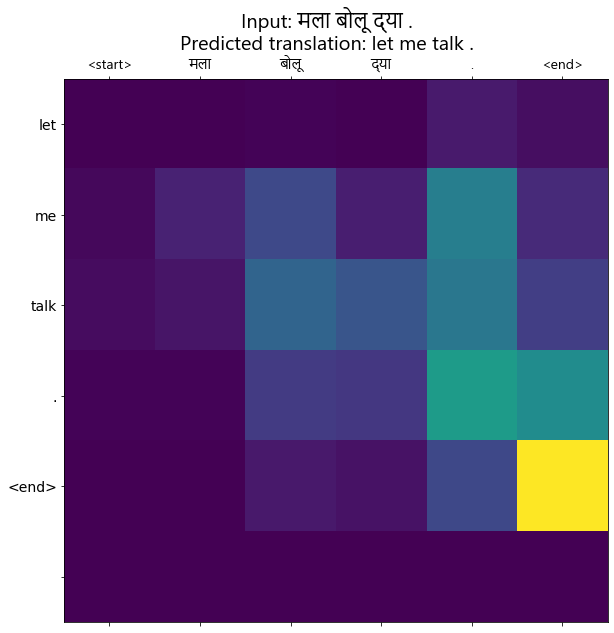

In [0]:
translate(u'मला बोलू द्या.')

Input: <start> टॉमने मेरीसाठी थोडं पाणी आणलं . <end>
Predicted translation: tom made mary some water . <end> 


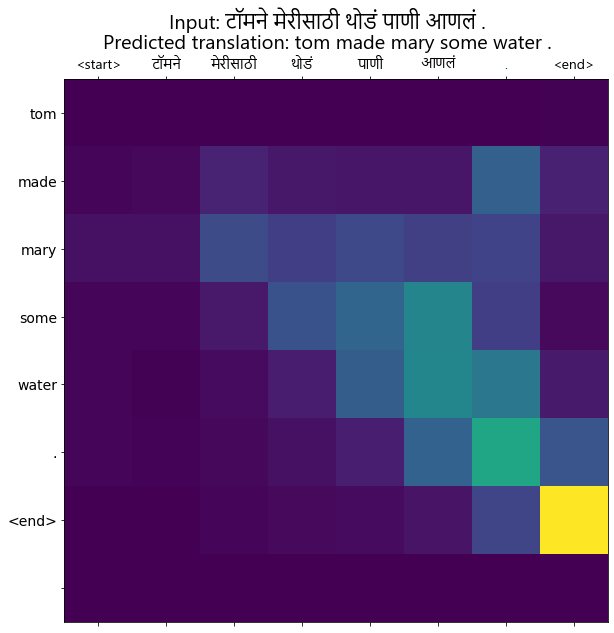

In [0]:
translate(u'टॉमने मेरीसाठी थोडं पाणी आणलं.')

Input: <start> तू नेहमीच माझ्यावर रागावलेला असतोस . <end>
Predicted translation: you're always angry with me . <end> 


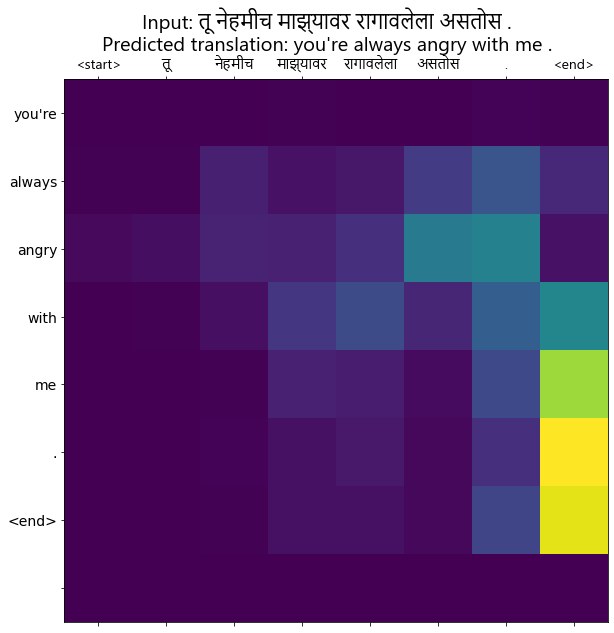

In [0]:
translate(u'तू नेहमीच माझ्यावर रागावलेला असतोस.')

Input: <start> तुला पाहते रे . <end>
Predicted translation: you can find a fool . <end> 


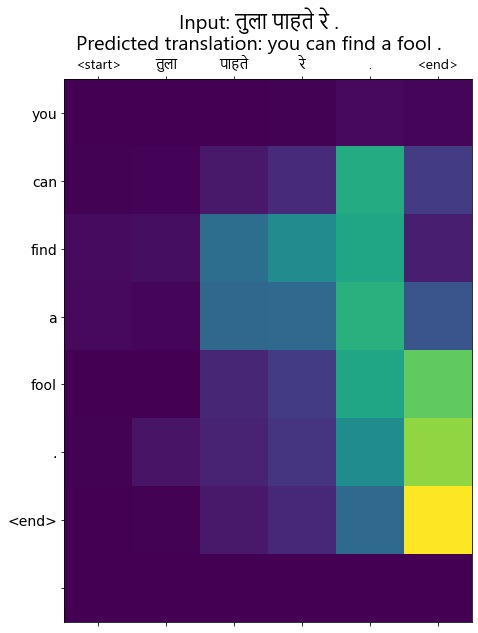

In [0]:
translate(u'तुला पाहते रे.')#चला हवा येऊ द्या

Input: <start> चला हवा येऊ द्या . <end>
Predicted translation: let's find a movie . <end> 


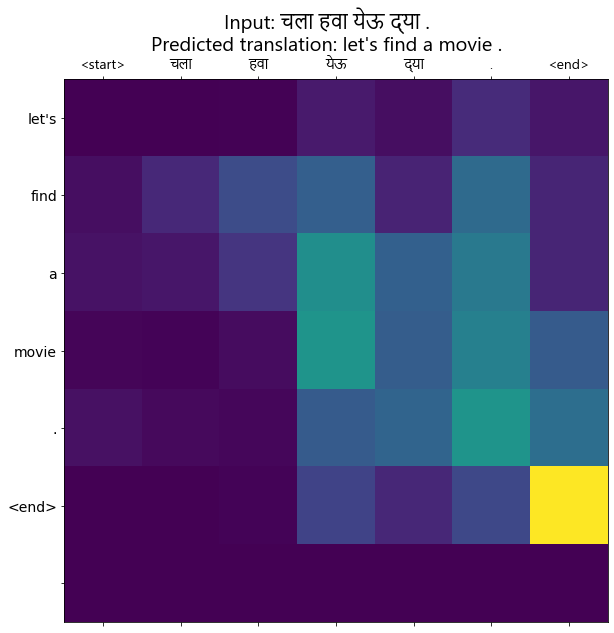

In [0]:
translate(u'चला हवा येऊ द्या.')#रात्रीस ख़ेल चाले

Input: <start> हे तुम्ही नक्की स्वतःहून करू शकता का ? <end>
Predicted translation: can you do this for you do this ? <end> 


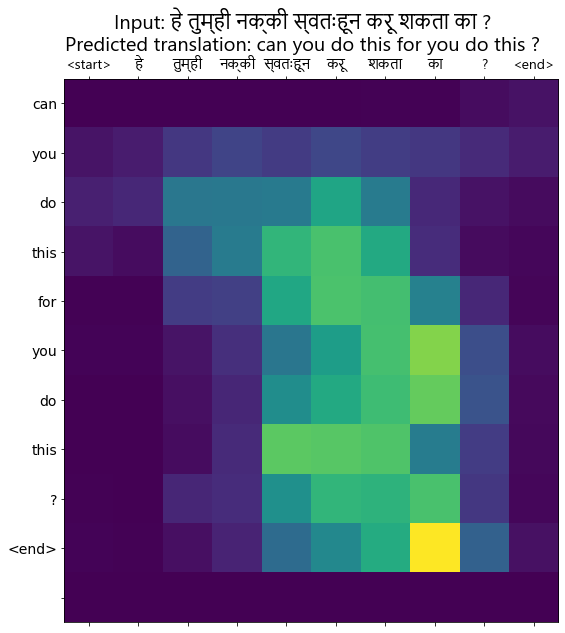

In [0]:
translate(u'हे तुम्ही नक्की स्वतःहून करू शकता का?')

Input: <start> मी एक इंग्रजी पुस्तक विकत घेतलं , पण ते समजायला कठीण होतं . <end>
Predicted translation: i bought a book , i didn't buy a week . <end> 


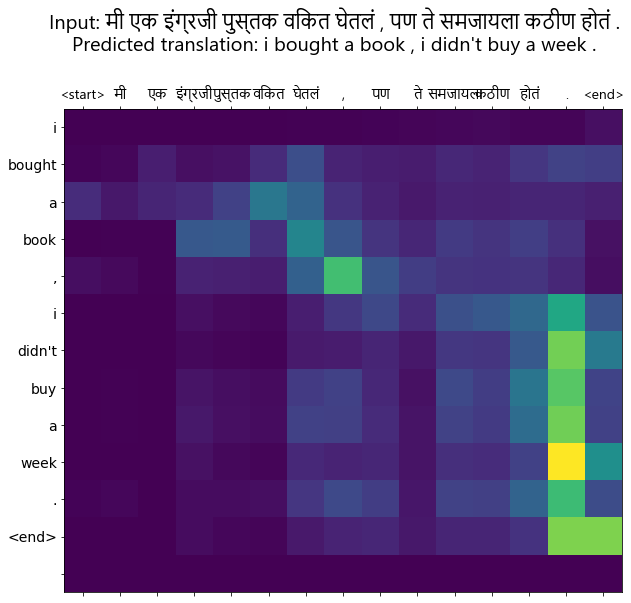

In [0]:
translate(u'मी एक इंग्रजी पुस्तक विकत घेतलं, पण ते समजायला कठीण होतं."माझ्याकडे गर्लफ्रेंड नसेल, पण कमीतकमी मी श्रीमंत तरी आहे," टॉम म्हणाला.')#हवामानाबद्दल तक्रार करण्यात काही अर्थ नाही.

Input: <start> लोकं आपल्याकडे बघत असली तर काय फरक पडतो ? <end>
Predicted translation: what else do you say all the game ? <end> 


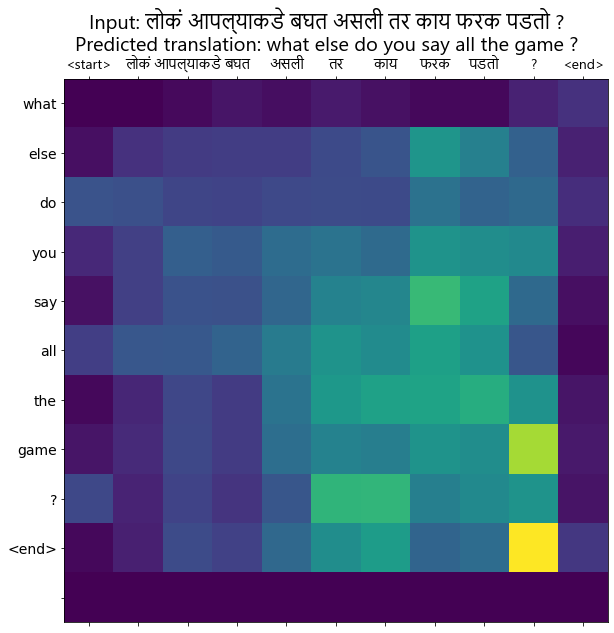

In [0]:
translate(u'लोकं आपल्याकडे बघत असली तर काय फरक पडतो?')